## Defender Clustering using Target and Catch Probability Models

The goal of this analysis is to group defensive players in the NFL based on their ability to defend in the passing game. There are a few components to that. One is the defender's ability to affect the result of a pass targeting the player they are guarding. I created a model to predict the probability of completing the catch for each defender guarding a targeted receiver on every throw.

In order to truly judge individual defensive play, especially for defensive backs, I don't want to only consider performance on passes targeting the guarded receiver. Smart offenses know to not even target the best defenders at all. To account for that, I've first created a model to predict the probability the guarded receiver will be targeted for each defender throughout the play.

For both models, there are two elements that are ultimately included in the clustering approach:
* Average target/completion probability - how well a defender is able to put himself in a position to not be targeted or not allow a reception
* Average target/completion probability over expected - how a specific defender performs relative to how an average player would *in the same situations*.

In [1]:
library(tidyverse)

# reading in non-tracking data
# includes schedule info for games
df_games <- read_csv("../input/nfl-big-data-bowl-2021/games.csv",
                    col_types = cols())
# includes play-by-play info on specific plays
df_plays <- read_csv("../input/nfl-big-data-bowl-2021/plays.csv",
                    col_types = cols())
# includes background info for players
df_players <- read_csv("../input/nfl-big-data-bowl-2021/players.csv",
                      col_types = cols())
# includes targeted receiver by play
df_targetedReceiver <- read_csv("../input/nfl-big-data-bowl-2021-bonus/targetedReceiver.csv",
                      col_types = cols())
# reading tracking data for each week
# weeks of NFL season
weeks <- seq(1, 17)
df_tracking <- data.frame()
# iterating through all weeks
for(w in weeks){    
    # temperory dataframe used for reading week for given iteration
    df_tracking_temp <- read_csv(paste0("../input/nfl-big-data-bowl-2021/week",w,".csv"),
                                col_types = cols())    
    # storing temporary dataframe in full season dataframe
    df_tracking <- bind_rows(df_tracking_temp, df_tracking)                                
}
rm(df_tracking_temp)

# data preparation
# add the targeted receiver's ID to each play
df_plays <- inner_join(df_plays,
                       df_targetedReceiver, 
                       by = c("gameId", "playId"))
# add the name of the targeted receiver
df_players_slim <- df_players[c("nflId", "displayName")]
df_plays <- left_join(df_plays,
                      df_players_slim, 
                      by = c("targetNflId" = "nflId"))
df_plays <- df_plays %>% rename(targetedReceiver = displayName)
rm(df_players_slim)
# filter out plays where the pass result is NA or R
df_plays <- df_plays[!is.na(df_plays$passResult),]
df_plays <- df_plays[df_plays$passResult != 'R',]
# standardize yardline
df_plays <- df_plays %>% mutate(
                                yardline100 = ifelse(possessionTeam == yardlineSide, yardlineNumber, 100 - yardlineNumber),
                                yardsToGoal = ifelse(possessionTeam == yardlineSide, 100 - yardlineNumber, yardlineNumber))
#Standardizing tracking data so its always in direction of offense going right
df_tracking <- df_tracking %>% mutate(
                                    x = ifelse(playDirection == "left", 120-x, x),
                                    y = ifelse(playDirection == "left", 160/3 - y, y))
# add home and away teams to the plays df
df_games_slim <- subset(df_games, select = c(gameId, homeTeamAbbr, visitorTeamAbbr))
df_plays <- left_join(df_plays,
                     df_games_slim,
                     by = "gameId")
rm(df_games_slim)
# loop through games to flag the home and away team in separate rows
df_games_double <- data.frame("gameId" = rep(0, 2*nrow(df_games)), "teamType" = rep(c("home", "away"),nrow(df_games)), "teamAbbr" = rep(NA, 2*nrow(df_games)))
for (i in 1:nrow(df_games)){
    df_games_double$gameId[2*i-1] <- df_games$gameId[i]
    df_games_double$gameId[2*i] <- df_games$gameId[i]
    df_games_double$teamAbbr[2*i-1] <- df_games$homeTeamAbbr[i]
    df_games_double$teamAbbr[2*i] <- df_games$visitorTeamAbbr[i]
}
# join team abbrevs to the tracking data
df_tracking <- left_join(df_tracking,
                         df_games_double, 
                         by = c("gameId", "team" = "teamType"))
rm(df_games_double)
# add possession team abbrev to the tracking data
df_plays_posTeam <- df_plays[c("gameId", "playId", "possessionTeam")]
df_tracking <- left_join(df_tracking,
                         df_plays_posTeam, 
                         by = c("gameId", "playId"))
rm(df_plays_posTeam)
# add a column to the tracking data for which side of the ball the player is on
df_tracking <- df_tracking %>% mutate(
                                    sideOfBall = ifelse(teamAbbr == possessionTeam, "offense", "defense"))
# adding a flag to the plays table if a play is irregular - in this case that's spikes and fake punts/FGs
df_plays <- df_plays %>% mutate(
                                weird_play = ifelse(is.na(offenseFormation) & typeDropback == "UNKNOWN", 1, 0))
# add the weird play flag to the tracking data in order to drop them from the tracking data
df_plays_drop_weird <- subset(df_plays, weird_play == 1, select = c(gameId, playId, weird_play))
df_tracking <- left_join(df_tracking,
                         df_plays_drop_weird, 
                         by = c("gameId", "playId"))
rm(df_plays_drop_weird)
# drop the weird plays from the tracking data and other unnecessary columns
df_tracking <- df_tracking %>% filter(
                                    is.na(weird_play)) %>%
                                select(
                                    -c(weird_play, a, dis, dir, jerseyNumber, team, playDirection, route, possessionTeam, s, o))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Data Preparation

For this analysis, I will be analyzing each defender's performance on all pass plays in 2018 using the frames of the tracking data from when the ball is snapped through the result of the pass.

Also, non-standard pass plays were removed from the dataset to reduce the noise in the data. This applies to spikes, field goal/punt fakes, and plays with offsetting penalties.

In [2]:
# add a flag to the track the last frame we need to care about for target/completion probability
df_tracking <- df_tracking %>% mutate(
                                    lastFrameCan = ifelse(event %in% c("pass_outcome_touchdown", "pass_outcome_incomplete", "pass_outcome_caught", 
                                                                       "pass_outcome_interception","qb_sack", "qb_strip_sack"), 1, 0))
# create a table with the first frame where a play ending frame is recorded
df_final_frames <- subset(df_tracking, lastFrameCan == 1, select = c(gameId, playId, frameId))
df_final_frames <- unique(df_final_frames)
df_final_frames <- df_final_frames %>% group_by(
                                            gameId, playId) %>%
                                        summarise(
                                            finalFrame = min(frameId))
# add first frame column to the tracking data and filter down to plays that happen up through that frame
df_tracking <- left_join(df_tracking,
                         df_final_frames, 
                         by = c("gameId", "playId"))
# identify the plays that didn't have a last frame
df_missing_last_frames <- subset(df_tracking, is.na(finalFrame), select = c(gameId, playId, frameId, event))
# mark the last frame as the frame with a tackle for the plays that have it
df_tackle_frames <- df_missing_last_frames %>% filter(
                                                    event == "tackle") %>%
                                                group_by(
                                                    gameId, playId) %>%
                                                summarise(
                                                    lastFrame2 = min(frameId))
# join the those plays with the last frame from tackles to the table of missing last frame plays
df_missing_last_frames <- left_join(df_missing_last_frames,
                                    df_tackle_frames,
                                    by = c("gameId", "playId"))
# mark the last frame for the remaining plays as the last non-None event
df_other_frames <- df_missing_last_frames %>% filter(
                                                    is.na(lastFrame2) & event != "None") %>%
                                                group_by(
                                                    gameId, playId) %>%
                                                summarise(
                                                    lastFrame3 = max(frameId))
# join those plays back to the missing frames table and get one last frame column per play
df_missing_last_frames <- left_join(df_missing_last_frames,
                                    df_other_frames,
                                    by = c("gameId", "playId"))
df_missing_last_frames <- df_missing_last_frames %>% mutate(
                                                            lastFrameConsol = ifelse(is.na(lastFrame2), lastFrame3, lastFrame2)) %>%
                                                        group_by(
                                                            gameId, playId) %>%
                                                        summarise(
                                                            lastFrameNew = min(lastFrameConsol))
# join the missing last frames back to tracking and consolidate the final frame column then filter to only frames up through the final frame
df_tracking <- left_join(df_tracking,
                         df_missing_last_frames, 
                         by = c("gameId", "playId"))
df_tracking <- df_tracking %>% mutate(
                                    lastFrameConsol = ifelse(is.na(finalFrame), lastFrameNew, finalFrame)) %>%
                                filter(
                                    frameId <= lastFrameConsol)
# delete the old tables and columns
rm(df_final_frames)
rm(df_missing_last_frames)
rm(df_tackle_frames)
rm(df_other_frames)
df_tracking <- subset(df_tracking, select = -c(lastFrameCan, finalFrame, lastFrameNew, lastFrameConsol))
# identify the frame on each play when the ball was snapped
df_snap_frames <- subset(df_tracking, event == "ball_snap", select = c(gameId, playId, frameId))
df_snap_frames <- unique(df_snap_frames)
df_snap_frames <- df_snap_frames %>% group_by(
                        gameId, playId) %>%
                    summarise(
                        snapFrame = max(frameId))
# add the snap frame to the tracking data and identify any plays without one
df_tracking <- left_join(df_tracking,
                         df_snap_frames, 
                         by = c("gameId", "playId"))
# filter out the frames through the ball snap
df_tracking <- subset(df_tracking, frameId > snapFrame)

`summarise()` regrouping output by 'gameId' (override with `.groups` argument)

`summarise()` regrouping output by 'gameId' (override with `.groups` argument)

`summarise()` regrouping output by 'gameId' (override with `.groups` argument)

`summarise()` regrouping output by 'gameId' (override with `.groups` argument)

`summarise()` regrouping output by 'gameId' (override with `.groups` argument)



The next step was to use the tracking data to identify the offensive player each defender was guarding at each frame, referred to as the receiver, but that player can be any Running Back, Full Back, Tight End, or Wide Receiver who was on the field as an eligible target.

For simplicity, the receiver that is closest to the defender is who I assigned that defender as guarding at each frame.

In [3]:
# create separate tracking tables for offense and defense to not add irrelevant columns to one side
df_tracking_def <- subset(df_tracking, sideOfBall == "defense")
df_tracking_off <- subset(df_tracking, sideOfBall == "offense")
# remove side of ball from each tracking table
df_tracking_def <- subset(df_tracking_def, select = -c(sideOfBall))
df_tracking_off <- subset(df_tracking_off, select = -c(sideOfBall))
# add a flag to the tracking data for if the player is a typical offensive receiver
off_rec <- c("FB", "HB", "RB", "TE", "WR")
df_tracking_off <- df_tracking_off %>% mutate(
                                            offRec = ifelse(position %in% off_rec, 1, 0))
# create a table of the first frame for each play with only the offenseive receivers
df_tracking_first_frame <- subset(df_tracking_off, frameId == snapFrame + 1 & offRec == 1, select = c(gameId, playId, nflId))
df_tracking_first_frame <- unique(df_tracking_first_frame)
# loop through the first frame table and add the receiver number for the play for each play
df_tracking_first_frame <- df_tracking_first_frame %>% arrange(gameId, playId)
df_tracking_first_frame$recNum <- 0
df_tracking_first_frame$recNum[1] <- 1
for (i in 2:nrow(df_tracking_first_frame)){
    if (df_tracking_first_frame$playId[i] == df_tracking_first_frame$playId[i-1]){
        df_tracking_first_frame$recNum[i] <- df_tracking_first_frame$recNum[i-1] + 1
    }
    else{
        df_tracking_first_frame$recNum[i] <- 1
    }
}
# use the spread function to create a new column for each recNum and grab the nflId for each play into a new row
df_play_rec <- spread(df_tracking_first_frame, recNum, nflId)
df_play_rec <- df_play_rec %>% rename(
                                    rec1Id = "1",
                                    rec2Id = "2",
                                    rec3Id = "3",
                                    rec4Id = "4",
                                    rec5Id = "5")
rm(df_tracking_first_frame)
# join receiver IDs back to the tracking data for each frame
df_tracking_def <- left_join(df_tracking_def,
                             df_play_rec, 
                             by = c("gameId", "playId"))
df_tracking_off <- left_join(df_tracking_off,
                             df_play_rec, 
                             by = c("gameId", "playId"))
rm(df_play_rec)
# gather the receiver IDs for each defender at each frame
df_def_gather <- df_tracking_def %>% select(
                                        gameId, playId, frameId, nflId, x, y, rec1Id, rec2Id, rec3Id, rec4Id, rec5Id) %>%
                                    gather(
                                        key = "recNum", value = "recId", rec1Id:rec5Id)
# join the offensive receivers' locations for each defender-receiver pair per frame
df_tracking_off_slim <- subset(
                            df_tracking_off, select = c(gameId, playId, frameId, nflId, x, y)) %>%
                        rename(
                            xRec = x,
                            yRec = y)
df_def_gather <- left_join(df_def_gather,
                           df_tracking_off_slim,
                           by = c("gameId", "playId", "frameId", "recId" = "nflId"))
# calculate the distance for each defender receiver pair
df_def_gather <- df_def_gather %>% mutate(
                                        recDist = sqrt((x - xRec)^2 + (y - yRec)^2))
# group by the game, play, frame, defender to identify the minimum distance
df_def_min_dist <- df_def_gather %>% group_by(
                                        gameId, playId, frameId, nflId) %>%
                                    summarise(
                                        minDist = min(recDist, na.rm = TRUE))
# join the min dist table to the gather table to add each defender's min dist
df_def_gather <- left_join(df_def_gather,
                           df_def_min_dist,
                           by = c("gameId", "playId", "frameId", "nflId"))
# filter gather df to only the defender receiver pairs where the distance is the min distance for that defender
df_def_gather <- subset(df_def_gather, recDist == minDist)
# join the gathered df back to the original def tracking table
df_def_gather_slim <- subset(df_def_gather, select = -c(x, y, recNum, minDist))
df_tracking_def <- left_join(df_tracking_def,
                             df_def_gather_slim,
                             by = c("gameId", "playId", "frameId", "nflId"))
# remove unneeded cols from defensive tracking df and extra tables
df_tracking_def <- subset(df_tracking_def, select = -c(snapFrame, rec1Id, rec2Id, rec3Id, rec4Id, rec5Id))
rm(df_def_gather_slim)
rm(df_def_gather)
rm(df_def_min_dist)
rm(df_tracking_off_slim)
gc()

Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(recDist, na.rm = 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1215196,64.9,19978768,1067.0,31216824,1667.2
Vcells,330851118,2524.2,1217032707,9285.3,1520241991,11598.6


## Model Feature Selection

Now I have data on every defender per frame, where they are, who they're guarding, where the player they're guarding is, and how far they are from them.

We need to enrich this with the dependent variables:
* Was the receiver the defender was guarding targeted
* Did the receiver catch the ball

Features to add:
* xDistRec - x distance from defender to receiver
* yDistRec - y distance from defender to receiver
* yardline100 - line of scrimmage
* xDistScrim - x distance from the line of scrimmage
* xDistEZ - x distance from the endzone
* xDistEL - x distance from the end line/back of endzone
* yDistSL - y distance from the nearest sideline
* down
* yardsToGo
* defScoreMargin - the defensive team's score - the offensive team's score pre-snap
* timeRemGame - time remaining in the game (minutes)
* playLen - play length (seconds)
* numPassRushers - how many pass rushers
* position type - group positions into DBs, LBs, Ss, DLs

The result of the pass was adjusted if a penalty occurred that impacted the pass outcome.

Roughing the passer or unnecessary roughness, for example, do not impact the completion probability.

Penalties that count as a completion:
* Defensive Pass Interference (DPI)
* Defensive Holding (DH)
* Illegal Contact (ICT)
* Facemask (FMM)

Penalties that negate a completion:
* Offensive Pass Interference (OPI)

In [4]:
# identify the first frame in order to get time a play started
df_first_frames <- df_tracking_def %>% group_by(
                                            gameId, playId) %>%
                                        summarise(
                                            firstFrame = min(frameId))
# look up the time of that first frame
df_frame_times <- df_tracking_def %>% group_by(
                                            gameId, playId, frameId) %>%
                                        summarise(
                                            firstTime = median(time))
df_first_frames <- left_join(df_first_frames,
                            df_frame_times,
                            by = c("gameId", "playId", "firstFrame" = "frameId"))
rm(df_frame_times)
# add the time at first frame column back to the tracking df
df_first_frames <- subset(df_first_frames, select = -c(firstFrame))
df_tracking_def <- left_join(df_tracking_def,
                            df_first_frames,
                            by = c("gameId", "playId"))
rm(df_first_frames)
# calculate the time difference from the beginning of the play to the current frame
df_tracking_def <- df_tracking_def %>% mutate(
                                            playLen = as.numeric(difftime(time, firstTime, units = "secs")))
# remove the unnecesary time columns
df_tracking_def <- subset(df_tracking_def, select = -c(time, firstTime))
# calculate other tracking features
df_tracking_def <- df_tracking_def %>% mutate(
                                            xDistRec = x - xRec,
                                            yDistRec = y - yRec,
                                            yDistSL = ifelse(53.3 - y < y, 53.3 - y, y),
                                            xDistEZ = 110 - x,
                                            xDistEL = 120 - x)
# calculate columns for defensive scoring margin and time remaining in game for each play
df_plays <- df_plays %>% mutate(
                                defScoreMargin = ifelse(possessionTeam == homeTeamAbbr,
                                                        preSnapVisitorScore - preSnapHomeScore, preSnapHomeScore - preSnapVisitorScore),
                                timeRemGame = case_when(
                                                quarter == 1 ~ as.numeric(gameClock) / 3600 + 45,
                                                quarter == 2 ~ as.numeric(gameClock) / 3600 + 30,
                                                quarter == 3 ~ as.numeric(gameClock) / 3600 + 15,
                                                TRUE         ~ as.numeric(gameClock) / 3600))
# add relevant cols from plays df
df_plays_slim <- subset(df_plays, select = c(gameId, playId, targetNflId, yardline100, down, yardsToGo, defScoreMargin, timeRemGame, numberOfPassRushers))
df_tracking_def <- left_join(df_tracking_def,
                            df_plays_slim,
                            by = c("gameId", "playId"))
rm(df_plays_slim)
# identify if covered player was targeted and calculate the defensive player's distance from the line of scrimmage
# removing 10 additional yards since the tracking data is zeroed at the back of the endzone, so it's shifted 10 yards relative to the actual yardlines
df_tracking_def <- df_tracking_def %>% mutate(
                                            recTarget = ifelse(recId == targetNflId, 1, 0),
                                            xDistScrim = x - yardline100 - 10)
# identify plays where penalties affected the pass result and adjust pass result accordingly
df_plays <- df_plays %>% mutate(
                                defPenalty = ifelse(is.na(penaltyCodes), 0, ifelse(str_detect(penaltyCodes, 'DPI|DH|ICT|FMM'), 1, 0)),
                                offPenalty = ifelse(is.na(penaltyCodes), 0, ifelse(str_detect(penaltyCodes, 'OPI'), 1, 0)),
                                passResultMod = ifelse(defPenalty == 1, 'C', ifelse(offPenalty == 1 & passResult == 'C', 'I', passResult)),
                                passComplete = ifelse(passResultMod == 'C', 1, 0),
                                weird_play = ifelse(offPenalty == 1 & defPenalty == 1, 1, ifelse(defPenalty == 1 & is.na(targetNflId), 1, weird_play)))
# flag the weird plays in the tracking data to remove them
df_weird_plays <- subset(df_plays, weird_play == 1, select = c(gameId, playId, weird_play))
df_tracking_def <- left_join(df_tracking_def,
                            df_weird_plays,
                            by = c("gameId", "playId"))
# remove the weird play rows
df_tracking_def <- subset(df_tracking_def, is.na(weird_play))
df_tracking_def <- subset(df_tracking_def, select = -c(weird_play))
rm(df_weird_plays)
# bring in pass result column to the tracking table
df_pass_result <- subset(df_plays, select = c(gameId, playId, passComplete))
df_tracking_def <- left_join(df_tracking_def,
                            df_pass_result,
                            by = c("gameId", "playId"))
rm(df_pass_result)
# flag if the covered player was targeted and caught the pass
df_tracking_def <- df_tracking_def %>% mutate(
                                            recCatch = ifelse(recTarget == 1 & passComplete == 1, 1, 0))
# remove any rows where there is no receiver
df_tracking_def <- subset(df_tracking_def, !is.na(recId), select = -c(passComplete))
# group positions
df_tracking_def <- df_tracking_def %>% filter(
                                            position != "TE" & position != "WR") %>%
                                        mutate(
                                            posDB = ifelse(position %in% c("CB", "DB"), 1, 0),
                                            posS = ifelse(position %in% c("FS", "S", "SS"), 1, 0),
                                            posDL = ifelse(position %in% c("DE", "DL", "DT", "NT"), 1, 0),
                                            posLB = ifelse(position %in% c("ILB", "LB", "MLB", "OLB"), 1, 0))
# drop any other rows with NAs
df_tracking_def <- df_tracking_def %>% drop_na()
gc()

`summarise()` regrouping output by 'gameId' (override with `.groups` argument)

`summarise()` regrouping output by 'gameId', 'playId' (override with `.groups` argument)



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1172636,62.7,15983015,853.6,31216824,1667.2
Vcells,429452107,3276.5,1217032707,9285.3,1520241991,11598.6


## Target Probability Model

First I predict the likelihood the defender is targeted at each frame based on relative position to the receiver they're guarding. The training set had over 4 million observations.

An XGBoost binary classification model was used. I performed a 5 fold cross validation model with the following parameters:
* eta = 0.3 (learning rate)
* gamma = 0 (regularization parameter, set to zero since overfitting wasn't the primary issue)
* max_depth = 10 (experimented with tree depths of 3-10 and found the bigger trees were necessary to capture the signal)
* nrounds = 100 (wanted to ensure enough training)

Based on the cross val results, the final model used 80 rounds of training.

The model found consistent accuracy metrics on the test set. With that result giving us confidence in the model, it's used to predict the target probability across the entire dataset. Then the probability is compared to the actual result in order to obtain a target probability over expected measure for each player across all of their plays. Each player's true target rate was calculated as well defined as the percentage of plays where the receiver they're guarding for at least half of the frames was the targeted receiver.

As mentioned in the introduction, there are two outputs of this model that can be used to assess defender talent/performance. The Average Target Probability is the average predicted probability of that defender being targeted for each frame of each play. This measures how well the defender is able to guard the receiver to discourage the QB from throwing to the receiver. Note that this probability is an absolute measure based solely on that defender at that frame relative to others in similar situations across the season. It is not relative to the defender's teammates on that particular play.

Taking that Average Target Probability a step further leads to Defensive Target Probability Over Expected (DTPOE). DTPOE takes the target probability and subtracts it from the actual result. The interpretation for DTPOE is the higher the number, the more often that defender is targeted than an average player in the same situation would be. This could mean that offenses are specifically targeting that defender. For low DTPOE values, that could be interpreted as defenders who are respected and are thrown at less often than an average defender would be in the same spot.

Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




[1]	train-error:0.177356 
Will train until train_error hasn't improved in 10 rounds.

[11]	train-error:0.174712 
[21]	train-error:0.171704 
[31]	train-error:0.168603 
[41]	train-error:0.165047 
[51]	train-error:0.161844 
[61]	train-error:0.158087 
[71]	train-error:0.154376 
[80]	train-error:0.151773 


[1] 0.8436269

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'nflId', 'gameId' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



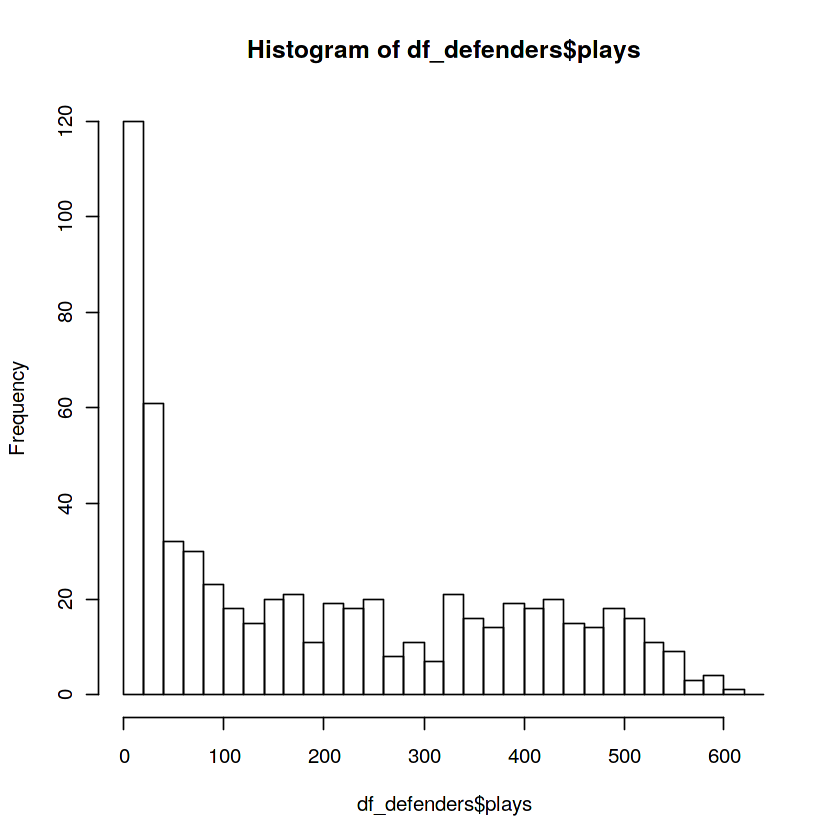

In [5]:
require(xgboost)
# finalize feature dataframe
thresholdDist <- 10
df_tracking_def <- subset(df_tracking_def, recDist < thresholdDist)
X <- subset(df_tracking_def, select = c(nflId, posDB, posS, posDL, posLB, recDist, xDistRec, yDistRec, xDistScrim, xDistEZ, xDistEL, yDistSL, playLen, 
                                        yardline100, down, yardsToGo, defScoreMargin, timeRemGame, numberOfPassRushers))
y <- subset(df_tracking_def, select = c(recTarget))
# split into train and test
set.seed(12493)
split_pct <- 0.75  
sample <- sample.int(n = nrow(X), size = floor(.75*nrow(X)), replace = FALSE)
X_train <- X[sample, ]
X_test <- X[-sample, ]
y_train <- y[sample, ]
y_test <- y[-sample, ]
# convert dataframes to matrices
X_train_mat <- as.matrix(X_train)
y_train_mat <- as.matrix(y_train)
X_test_mat <- as.matrix(X_test)
y_test_mat <- as.matrix(y_test)
# fit model based on best set of params
set.seed(510)
params <- list(booster = "gbtree", objective = "binary:logistic", eta = 0.3, gamma = 0, max_depth = 10, min_child_weight = 1, subsample = 1, colsample_bytree = 1)
target_mod <- xgboost(params = params, data = X_train_mat[ , -1], label = y_train_mat, nrounds = 80, print_every_n = 10, early_stopping_rounds = 10, 
                         maximize = F , eval_metric = "error")
# predict on the test set
test_pred_probs <- predict(target_mod, X_test_mat[ , -1])
mean(as.numeric(test_pred_probs > 0.5) == y_test_mat)
# predict the whole X set to add to table
targetProb <- predict(target_mod, as.matrix(X[ , -1]))
X$targetProb <- targetProb
X$recTarget <- y$recTarget
# find the target probabilities for each defender
X <- X %>% mutate(
                targetVsExp = recTarget - targetProb)
df_def_target_probs <- X %>% group_by(
                                nflId) %>% 
                             summarise(
                                avgTargetProb = mean(targetProb),
                                cumDTPOE = sum(targetVsExp),
                                avgDTPOE = mean(targetVsExp))
# find the target rates for each defender
df_def_targets <- df_tracking_def %>% group_by(
                                            nflId, gameId, playId) %>%
                                      summarise(
                                            target = ifelse(mean(recTarget) > 0.5, 1, 0),
                                            targetGuard = sum(recTarget),
                                            frames = n(),
                                            team = first(teamAbbr))
df_def_target_rates <- df_def_targets %>% group_by(
                                                nflId) %>%
                                            summarise(
                                                targetRate = mean(target),
                                                plays = n(),
                                                team = first(team))
# join the target probs and rate tables together
df_defenders <- inner_join(df_def_target_probs,
                           df_def_target_rates,
                           by = "nflId")
rm(df_def_target_probs)
rm(df_def_target_rates)
# look at the distribution of number of plays
hist(df_defenders$plays, breaks=seq(0,650,20))
# remove players with less than 20 snaps
df_defenders <- df_defenders %>% filter(plays > 20)

## Target Model Results

The model performed strongly in both training and test sets. 85% of the target/no-target predictions were accurate in training and 84% in test.

XGBoost is a tree-based model, so we can tell which features are most critical to the prediction through the feature importance. For the target probability model, play level factors like time remaining in the game, line of scrimmage and tracking features like distance from sideline and the line of scrimmage matter the most.

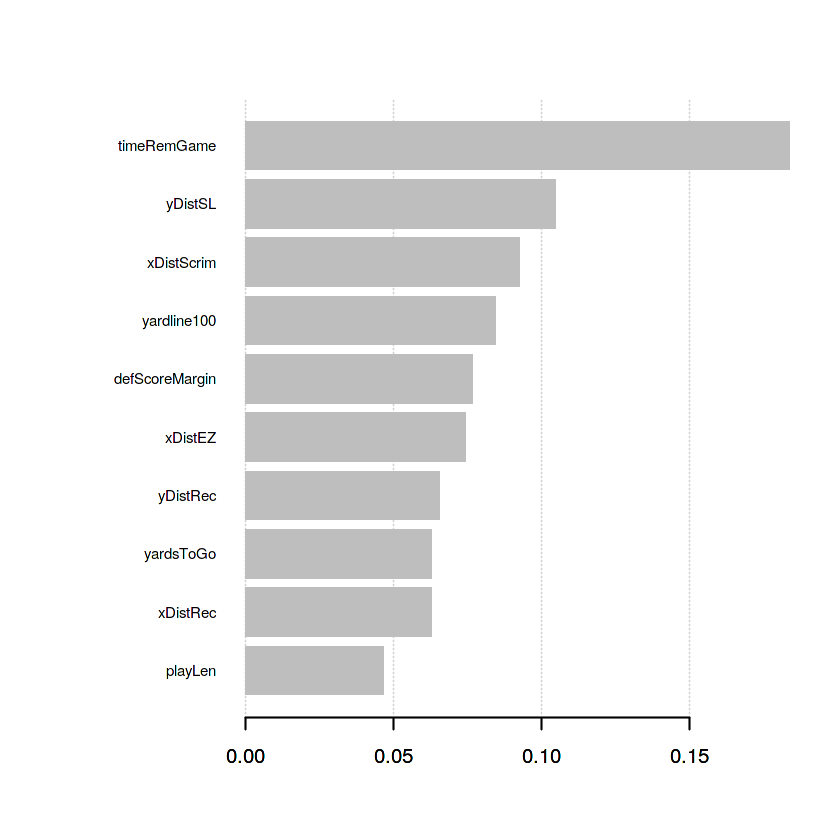

In [6]:
# feature importance
mat <- xgb.importance (feature_names = colnames(X[, -1]),model = target_mod)
xgb.plot.importance (importance_matrix = mat[1:10])

Below is a plot of the predicted target probabilities for the model. Probabilities are centered around 20% for any defender at a given frame. However there is a strong right tail of situations where a target became likely.

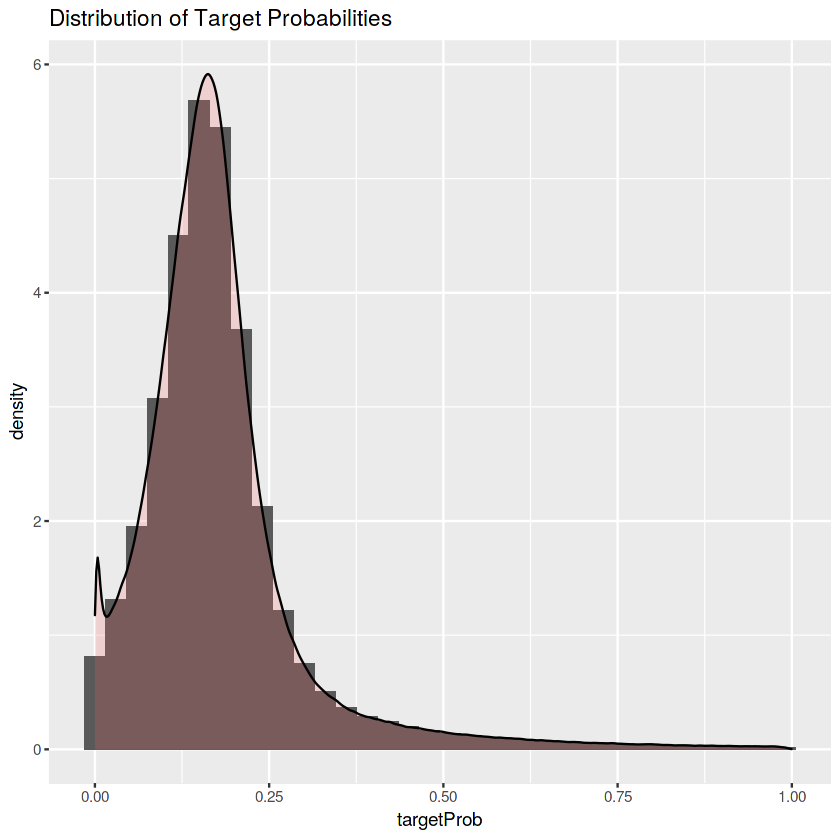

In [7]:
ggplot(X, aes(x=targetProb)) + 
 geom_histogram(aes(y=..density..), binwidth = 0.03)+
 geom_density(alpha=.2, fill="#FF6666") +
 ggtitle("Distribution of Target Probabilities")

The Average Target Probability distribution is normally distributed among NFL defenders. Defender Target Probability over Expectation however has a narrower spread centered on 0. This suggests it is unlikely for an individual player to be consistently under or over-targeted relative to expectation[](http://).

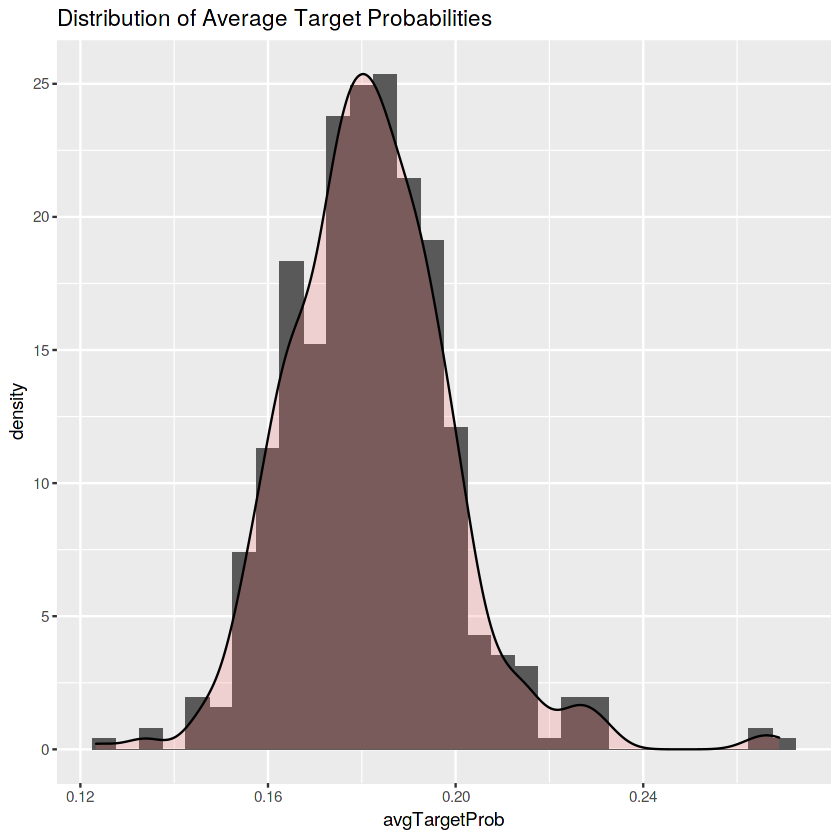

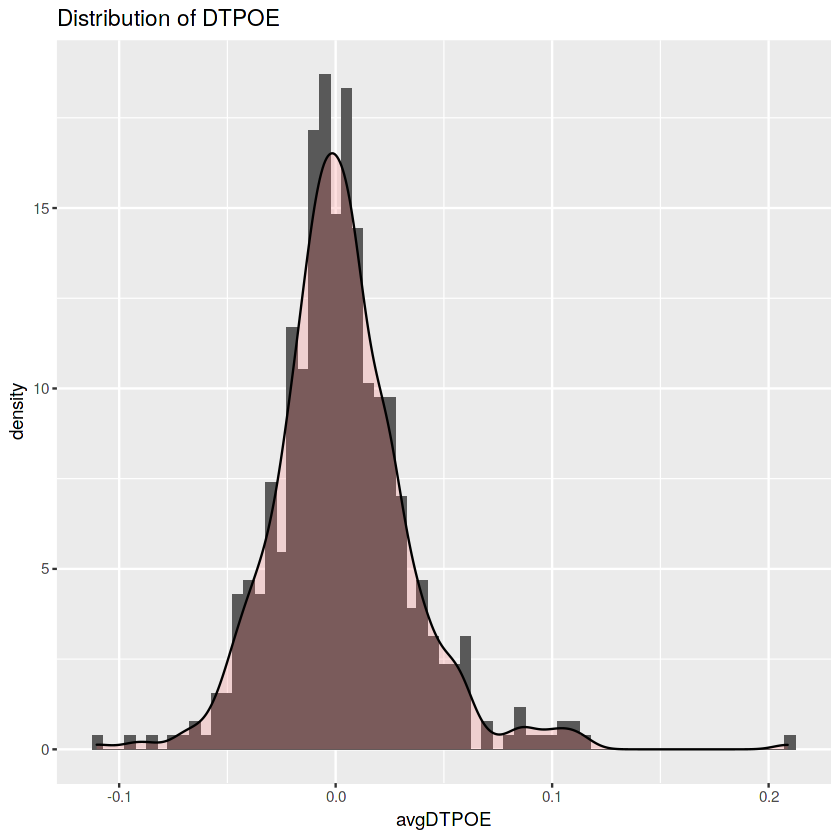

In [8]:
ggplot(df_defenders, aes(x=avgTargetProb)) + 
 geom_histogram(aes(y=..density..), binwidth = 0.005)+
 geom_density(alpha=.2, fill="#FF6666")  +
 ggtitle("Distribution of Average Target Probabilities")

ggplot(df_defenders, aes(x=avgDTPOE)) + 
 geom_histogram(aes(y=..density..), binwidth = 0.005)+
 geom_density(alpha=.2, fill="#FF6666") +
 ggtitle("Distribution of DTPOE")

Recognizing that the lower the DPTOE, the better, here is the top 10 among players who played more than 100 snaps.

In [9]:
# add player names and position to the defender table
df_players_slim <- subset(df_players, select = c(nflId, displayName, position))
df_defenders <- left_join(df_defenders,
                         df_players_slim,
                         by = "nflId")
rm(df_players_slim)
# group positions
df_defenders <- df_defenders %>% mutate(
                                        groupedPosition = case_when(
                                            position %in% c("CB", "DB") ~ "CB",
                                            position %in% c("FS", "S", "SS") ~ "S",
                                            position %in% c("DE", "DL", "DT", "NT") ~ "DL",
                                            position %in% c("ILB", "LB", "MLB", "OLB") ~ "LB",
                                            TRUE ~ "Other"
                                            )
                                        ) %>% 
                                filter(
                                        groupedPosition != "Other"
                            )
# get the top 10 lowest avgDTPOE players with more than 100 snaps 
df_defenders %>% arrange(
                        avgDTPOE) %>%
                    filter(
                        plays > 100) %>%
                    head(
                        10) %>%
                    select(
                        displayName, team, groupedPosition, plays, avgDTPOE, avgTargetProb, targetRate) %>%
                    rename(
                        Name = displayName,
                        Team = team,
                        Position = groupedPosition,
                        Plays = plays,
                        "Average DTPOE" = avgDTPOE,
                        "Target Probability" = avgTargetProb,
                        "Target Rate" = targetRate)

Name,Team,Position,Plays,Average DTPOE,Target Probability,Target Rate
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
Leon Hall,OAK,CB,198,-0.05690327,0.1691572,0.09595960
Richard Sherman,SF,CB,408,-0.05332727,0.1793668,0.11519608
Tavon Wilson,DET,S,154,-0.05258220,0.1853501,0.10389610
Montae Nicholson,WAS,S,224,-0.04735018,0.1912734,0.14285714
DeShawn Shead,DET,CB,165,-0.04709574,0.1724136,0.12727273
Kurt Coleman,NO,S,166,-0.04603380,0.1719584,0.09638554
K.J. Wright,SEA,LB,125,-0.04534165,0.1881988,0.12000000
Quincy Wilson,IND,CB,255,-0.04525218,0.1756078,0.13333333
Artie Burns,PIT,CB,171,-0.04506680,0.1928545,0.14619883


## Catch Probability Model

The first component to identifying defender talent was assessing the ability to guard receivers such that offenses do not target those receivers. The second comes in once the defender is targeted. We want to model how the defender affects the outcome of passing attempts. Strong defenders are expected to breakup, intercept, or otherwise impede passes from being caught.

For this model, I used the same framework as the Target Model with cross-fold validated XGBoost binary classification model. The dataset consisted only of the defenders guarding the receiver who was targeted on that play. The catch result was adjusted for penalties.

The output of this model is again twofold like the Target Model where the catch probability and probability over expected were predicted for each player at each frame.

In [10]:
# filter to only defenders guarding targeted receivers for the completion probability model
df_tracking_def_targets <- subset(df_tracking_def, recTarget == 1)
rm(df_tracking_def)
rm(df_tracking_off)
gc()
X <- subset(df_tracking_def_targets, select = c(nflId, posDB, posS, posDL, posLB, recDist, xDistRec, yDistRec, xDistScrim, xDistEZ, xDistEL, yDistSL, playLen, 
                                                yardline100, down, yardsToGo, defScoreMargin, timeRemGame, numberOfPassRushers))
y <- subset(df_tracking_def_targets, select = c(recCatch))
# split into train and test
set.seed(82920)
split_pct <- 0.75  
sample <- sample.int(n = nrow(X), size = floor(.75*nrow(X)), replace = FALSE)
X_train <- X[sample, ]
X_test <- X[-sample, ]
y_train <- y[sample, ]
y_test <- y[-sample, ]
# convert dataframes to matrices
X_train_mat <- as.matrix(X_train)
y_train_mat <- as.matrix(y_train)
X_test_mat <- as.matrix(X_test)
y_test_mat <- as.matrix(y_test)
# fit model based on best set of params
set.seed(829)
params <- list(booster = "gbtree", objective = "binary:logistic", eta = 0.3, gamma = 0, max_depth = 10, min_child_weight = 1, subsample = 1, colsample_bytree = 1)
comp_mod <- xgboost(params = params, data = X_train_mat[ , -1], label = y_train_mat, nrounds = 80, print_every_n = 10, early_stopping_rounds = 10, 
                         maximize = F , eval_metric = "error")
# predict on the test set
test_pred_probs <- predict(comp_mod, X_test_mat[ , -1])
mean(as.numeric(test_pred_probs > 0.5) == y_test_mat)
# predict the whole X set to add to table
compProb <- predict(comp_mod, as.matrix(X[ , -1]))
X$compProb <- compProb
X$recCatch <- y$recCatch
# find the target probabilities for each defender
X <- X %>% mutate(
                compVsExp = recCatch - compProb)
df_def_catch_probs <- X %>% group_by(
                                nflId) %>% 
                             summarise(
                                avgCompProb = mean(compProb),
                                cumDCPOE = sum(compVsExp),
                                avgDCPOE = mean(compVsExp))
# find completion rates for the frames a defender guarded the targeted receiver
df_def_catch_rates <- df_tracking_def_targets %>% group_by(
                                                        nflId) %>%
                                                    summarise(
                                                        compRate = mean(recCatch))
# join the catch model results to the defenders table
df_defenders <- left_join(df_defenders,
                         df_def_catch_probs,
                         by = "nflId")
df_defenders <- left_join(df_defenders,
                         df_def_catch_rates,
                         by = "nflId")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2368613,126.5,12786412,682.9,31216824,1667.2
Vcells,472616579,3605.8,1217032707,9285.3,1520241991,11598.6


[1]	train-error:0.331070 
Will train until train_error hasn't improved in 10 rounds.

[11]	train-error:0.255417 
[21]	train-error:0.197695 
[31]	train-error:0.146844 
[41]	train-error:0.119289 
[51]	train-error:0.098401 
[61]	train-error:0.075637 
[71]	train-error:0.064206 
[80]	train-error:0.053861 


[1] 0.9377328

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



## Catch Model Results

The Catch Model performed even better than the Target Model by predicting catches at a 95% accuracy in train and 94% in test. This suggests player tracking and play level data captures more signal in catch likelihood than target likelihood.

For the completion model, play level data appears to be far more important than the tracking data in predicting completion probability. Time remaining in the game, line of scrimmage, and score margin were the most critical features.

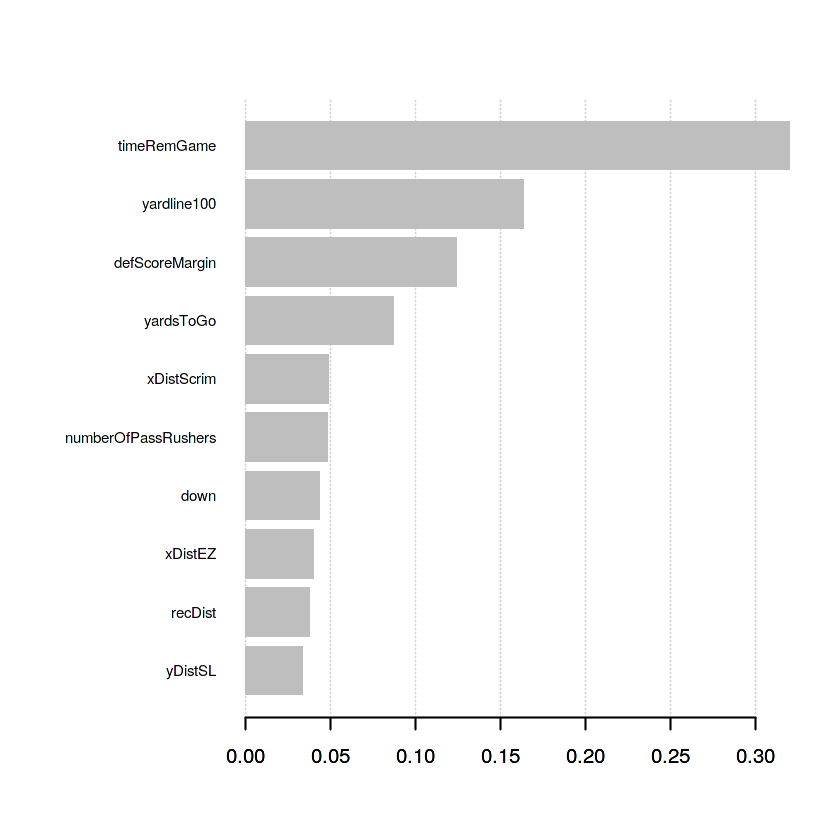

In [11]:
# feature importance
mat <- xgb.importance(feature_names = colnames(X[, -1]),model = comp_mod)
xgb.plot.importance(importance_matrix = mat[1:10])

Predicted completion probability is not normally distributed. The predictions tend to one extreme or the other with more likely to be caught. This is consistent with reality as more passes are caught than not.

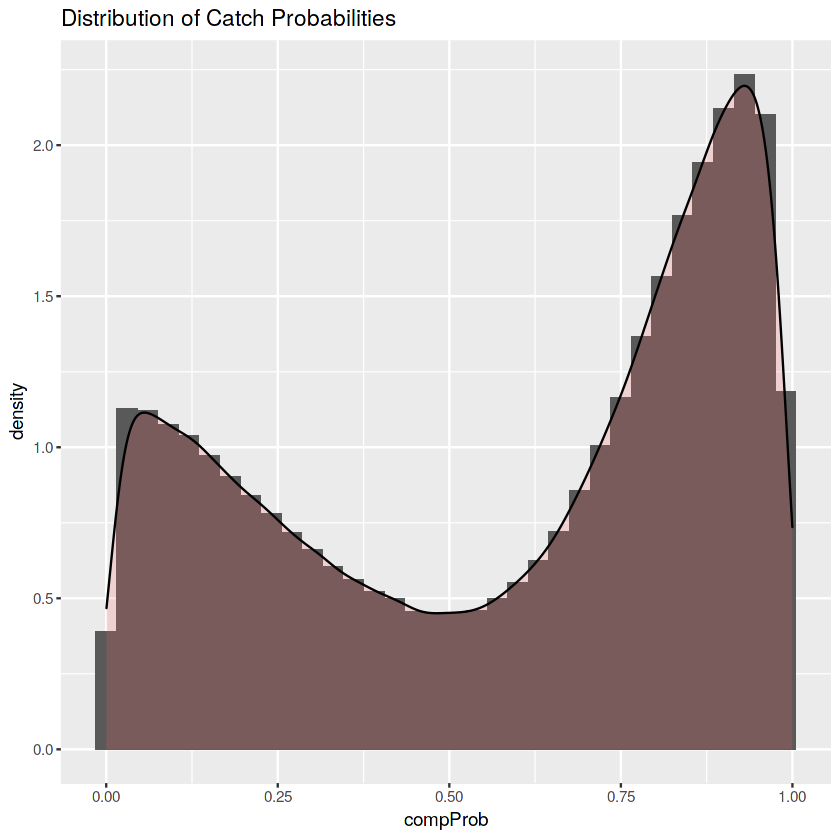

In [12]:
ggplot(X, aes(x=compProb)) + 
 geom_histogram(aes(y=..density..), binwidth = 0.03)+
 geom_density(alpha=.2, fill="#FF6666") +
 ggtitle("Distribution of Catch Probabilities")

Completion Probability is more spread out than Target Probability and has two peaks. This suggests there are factors that differentiate the ability of defenders to prevent completions. Defensive Completions over Expected does not share that same wide distribution, so the signal of defensive talent is in their ability to lower the probability of a completion. Defenders in the same situations seem to produce similar results as their peers.

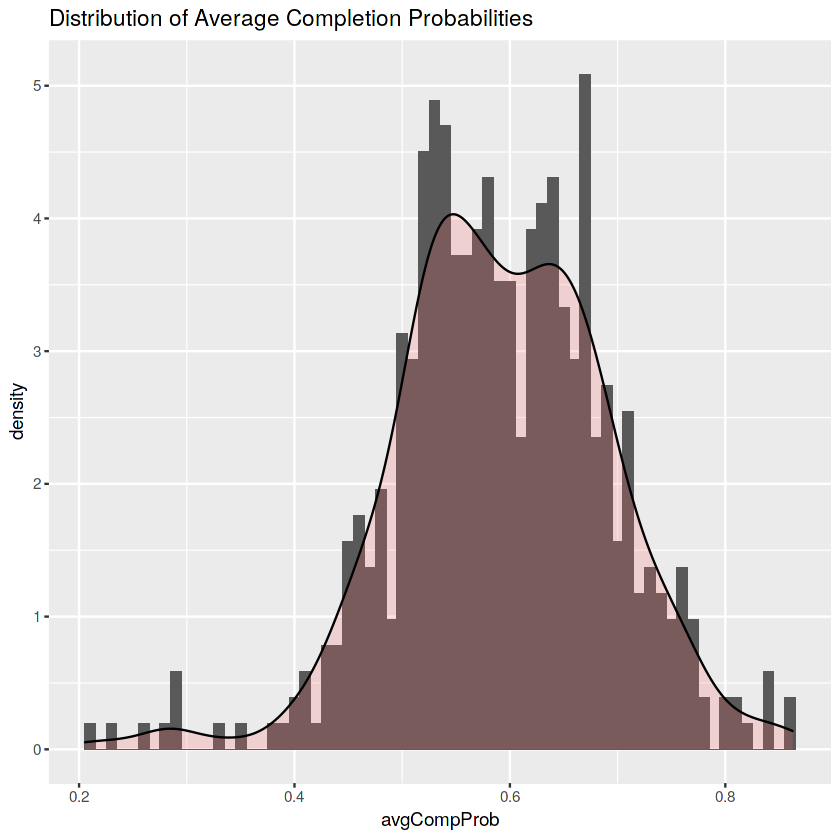

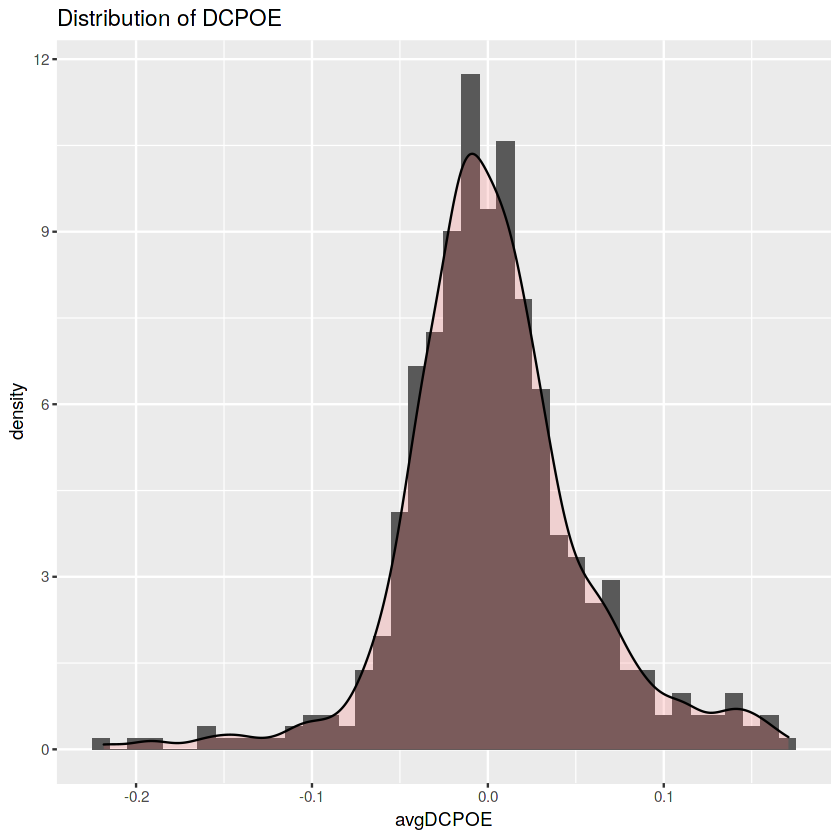

In [13]:
ggplot(df_defenders, aes(x=avgCompProb)) + 
 geom_histogram(aes(y=..density..), binwidth = 0.01)+
 geom_density(alpha=.2, fill="#FF6666") +
 ggtitle("Distribution of Average Completion Probabilities")

ggplot(df_defenders, aes(x=avgDCPOE)) + 
 geom_histogram(aes(y=..density..), binwidth = 0.01)+
 geom_density(alpha=.2, fill="#FF6666") +
 ggtitle("Distribution of DCPOE")

Here are the top 10 players with at least 100 snaps in terms of DCPOE.

In [14]:
# get 10 lowest DCPOE players
df_defenders %>% arrange(
                        avgDCPOE) %>%
                filter(
                        plays > 100) %>%
                head(
                        10) %>%
                select(
                        displayName, team, groupedPosition, plays, avgDCPOE, avgCompProb, compRate) %>%
                rename(
                        Name = displayName,
                        Team = team,
                        Position = groupedPosition,
                        Plays = plays,
                        "Average DCPOE" = avgDCPOE,
                        "Catch Probability" = avgCompProb,
                        "Catch Rate" = compRate)

Name,Team,Position,Plays,Average DCPOE,Catch Probability,Catch Rate
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
Eric Wilson,MIN,LB,153,-0.14414647,0.6733819,0.5292354
Holton Hill,MIN,CB,155,-0.11133425,0.4476174,0.3362832
Josh Harvey-Clemons,WAS,LB,151,-0.09885940,0.4911311,0.3922717
Nick Nelson,OAK,CB,156,-0.07858279,0.5033140,0.4247312
Lano Hill,SEA,S,156,-0.07313637,0.5256827,0.4525463
Sherrick McManis,CHI,CB,167,-0.06860945,0.4036348,0.3350254
Neville Hewitt,NYJ,LB,132,-0.06685429,0.6498868,0.5830325
Marlon Humphrey,BAL,CB,434,-0.06375267,0.4508186,0.3870659
Matt Milano,BUF,LB,376,-0.06295957,0.5346498,0.4716903


## Cluster defenders

Beyond looking at top 10/bottom 10 lists for individual metrics, the next level of analysis is exploration for trends among players across the metrics. Using an unsupervised learning approach like K-Means Clustering, players can be grouped based on performance.

Clustering provides two benefits. The first is a high-level understanding of player archetypes. Each cluster represents a different style of player. Recognizing what those styles are has value. The second comes by assigning each player to one of those archetypes. That better understanding of the style of player strengths allow for smarter team building and game planning.

A player archetype consisting of high targets but strong catch prevention, for example, could be a good fit for a defensive coach employing a heavy man coverage scheme knowing that even if that player is targeted, they have the ball skills to effectively defend the pass.

,Distance,Size
,<dbl>,<dbl>
Two_Clusters,0.01692051,0.000600162
Three_Clusters,0.07412964,0.001501899
Four_Clusters,2.33074583,0.008862376
Five_Clusters,0.93379086,0.001851375


,1,2,3
avgTargetProb,1.1637784,-0.4267526,-0.2329757
avgDTPOE,1.1313007,-0.2234591,-0.4066733
targetRate,1.3114817,-0.3210974,-0.4130217
avgCompProb,-0.4401716,0.8443826,-0.5549420
avgDCPOE,-0.1707358,0.7182612,-0.5831562
compRate,-0.4003620,0.9178819,-0.6458602


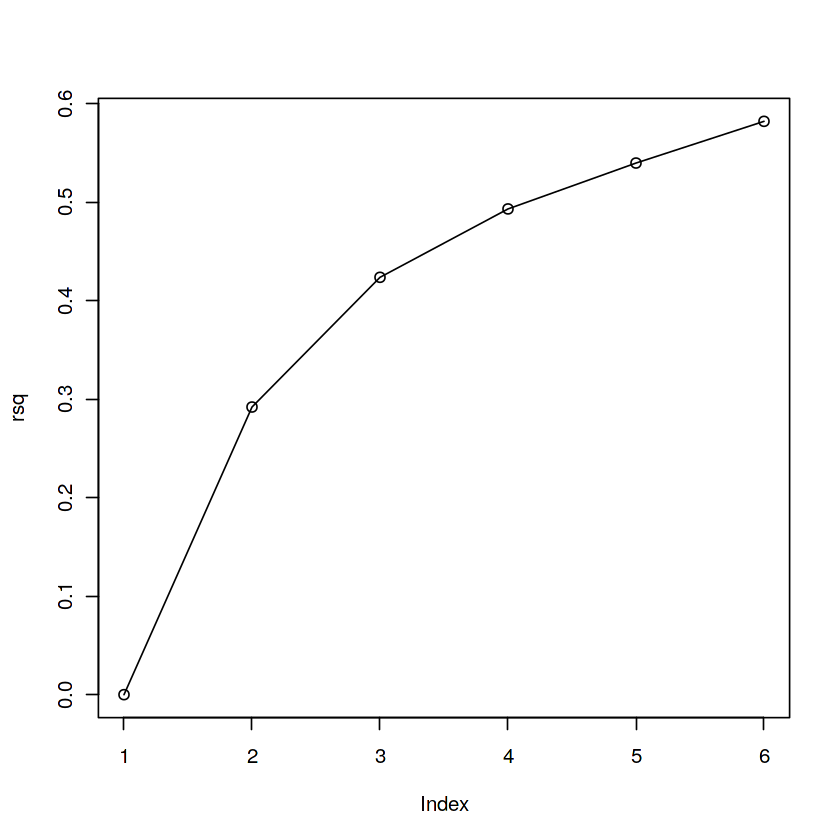

In [15]:
# start with clustering the average-based stats
X_avg <- subset(df_defenders, select = -c(cumDTPOE, cumDCPOE, plays, team, displayName, position, groupedPosition))
# split into train and test
set.seed(51016)
split_pct <- 0.75  
sample <- sample.int(n = nrow(X_avg), size = floor(.75*nrow(X_avg)), replace = FALSE)
X_train <- X_avg[sample, -1]
X_test <- X_avg[-sample, -1]
# create vector for r-squared calcs
rsq <- rep(0, 6)
# fit kmeans clusters with different number of clusters and record the rsq for each
set.seed(124)
def_clust_2 <- kmeans(scale(X_train), centers = 2, nstart = 75)
rsq[2] <- def_clust_2$betweenss / def_clust_2$totss
def_clust_3 <- kmeans(scale(X_train), centers = 3, nstart = 75)
rsq[3] <- def_clust_3$betweenss / def_clust_3$totss
def_clust_4 <- kmeans(scale(X_train), centers = 4, nstart = 75)
rsq[4] <- def_clust_4$betweenss / def_clust_4$totss
def_clust_5 <- kmeans(scale(X_train), centers = 5, nstart = 75)
rsq[5] <- def_clust_5$betweenss / def_clust_5$totss
def_clust_6 <- kmeans(scale(X_train), centers = 6, nstart = 75)
rsq[6] <- def_clust_6$betweenss / def_clust_6$totss
# plot rsquared's
plot(rsq)
lines(rsq)
# fit with test set to compare
set.seed(724)
train_size = nrow(X_train)
test_size = nrow(X_test)
def_clust_2_test <- kmeans(scale(X_test), centers = def_clust_2$centers, nstart = 1)
dist_diff_2 <- mean(apply((def_clust_2_test$centers - def_clust_2$centers)^2,1,sum))
size_diff_2 <- mean((def_clust_2_test$size / test_size - def_clust_2$size / train_size)^2)
def_clust_3_test <- kmeans(scale(X_test), centers = def_clust_3$centers, nstart = 1)
dist_diff_3 <- mean(apply((def_clust_3_test$centers - def_clust_3$centers)^2,1,sum))
size_diff_3 <- mean((def_clust_3_test$size / test_size - def_clust_3$size / train_size)^2)
def_clust_4_test <- kmeans(scale(X_test), centers = def_clust_4$centers, nstart = 1)
dist_diff_4 <- mean(apply((def_clust_4_test$centers - def_clust_4$centers)^2,1,sum))
size_diff_4 <- mean((def_clust_4_test$size / test_size - def_clust_4$size / train_size)^2)
def_clust_5_test <- kmeans(scale(X_test), centers = def_clust_5$centers, nstart = 1)
dist_diff_5 <- mean(apply((def_clust_5_test$centers - def_clust_5$centers)^2,1,sum))
size_diff_5 <- mean((def_clust_5_test$size / test_size - def_clust_5$size / train_size)^2)
# compare distance and size differences among cluster solutions
differences <- as.data.frame(cbind(rbind(Two_Clusters = dist_diff_2, Three_Clusters = dist_diff_3, Four_Clusters = dist_diff_4, Five_Clusters = dist_diff_5),
                                   rbind(size_diff_2, size_diff_3, size_diff_4, size_diff_5)))
colnames(differences) <- c("Distance", "Size")
differences
t(def_clust_3$centers)
# predict clusters for everyone
def_clust_3_all <- kmeans(scale(X_avg[, -1]), centers = def_clust_3$centers, nstart = 1)
# add the cluster label to the defender table
df_defenders$cluster <- def_clust_3_all$cluster
# create a table with the cluster centers
centers <- def_clust_3$centers
centers <- cbind("cluster" = c(1, 2, 3), centers)
centers <- as_tibble(centers) %>% rename(
                            avgTargetProbCenter = avgTargetProb,
                            avgDTPOECenter = avgDTPOE,
                            targetRateCenter = targetRate,
                            avgCompProbCenter = avgCompProb,
                            avgDCPOECenter = avgDCPOE,
                            compRateCenter = compRate)
# get scaled data for each player then add the centers to each player for their cluster
X_avg_scaled <- as_tibble(scale(X_avg[, -1]))
X_avg_scaled$nflId <- X_avg$nflId
X_avg_scaled$cluster <- def_clust_3_all$cluster
X_avg_scaled <- left_join(X_avg_scaled,
                         centers,
                         by = "cluster")
# calculate the distance from cluster center for each player
X_avg_scaled <- X_avg_scaled %>% mutate(
                                        distFromCenter = ((avgTargetProb - avgTargetProbCenter)^2 + (avgDTPOE - avgDTPOECenter)^2 + 
                                                          (targetRate - targetRateCenter)^2 + (avgCompProb - avgCompProbCenter)^2 + 
                                                          (avgDCPOE - avgDCPOECenter)^2 + (compRate - compRateCenter)^2)^0.5)
# join the distance from center to the defenders table
X_avg_scaled_slim <- subset(X_avg_scaled, select = c(nflId, distFromCenter))
df_defenders <- left_join(df_defenders,
                         X_avg_scaled_slim,
                         by = "nflId")
rm(X_avg_scaled_slim)

I decided to go with 3 clusters based on the r-squared value (0.42), the training/test set differences, even cluster sizes, and the interpretability of the clusters.

Cluster definitions:
1. Target Baiters - invite targets based high implied target probability, however they excel in defending passes shown by low catch probabilities and rates.
2. False Intimidators - low target rates and probabilities, but they give up completions more than average when targeted.
3. Shutdown Defenders - low completion rates and probabilities, low target rates and probabilities. Aren't thrown at often and defend well when they are.

In [16]:
# Cluster sizes
df_defenders %>% group_by(cluster) %>% summarise(count = n())

`summarise()` ungrouping output (override with `.groups` argument)



cluster,count
<int>,<int>
1,112
2,202
3,197


The clusters allow us to better categorize players. Here are examples of the ones who are most emblematic of each cluster.

Cluster 1:

In [17]:
df_defenders %>% filter(
                        cluster == 1 & plays > 50) %>%
                arrange(
                        distFromCenter) %>%
                head(10) %>%
                select(
                        displayName, team, groupedPosition, plays, avgDTPOE, avgTargetProb, targetRate, avgDCPOE, avgCompProb, compRate) %>%
                rename(
                        Name = displayName,
                        Team = team,
                        Position = groupedPosition,
                        Plays = plays,
                        "Average DTPOE" = avgDTPOE,
                        "Target Probability" = avgTargetProb,
                        "Target Rate" = targetRate,
                        "Average DCPOE" = avgDCPOE,
                        "Catch Probability" = avgCompProb,
                        "Catch Rate" = compRate)

Name,Team,Position,Plays,Average DTPOE,Target Probability,Target Rate,Average DCPOE,Catch Probability,Catch Rate
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Troy Hill,LA,CB,219,0.03894251,0.2030980,0.2100457,-0.001106490,0.5610087,0.5599022
Ronald Darby,PHI,CB,346,0.03455775,0.2014898,0.2196532,-0.013881481,0.5193724,0.5054910
Kendrick Lewis,TEN,S,106,0.03666432,0.2052601,0.2358491,0.004188816,0.5142771,0.5184659
Tre Boston,ARI,S,372,0.03603251,0.1993083,0.2204301,-0.013929604,0.5194718,0.5055422
Reshad Jones,MIA,S,264,0.02180937,0.2017534,0.2386364,-0.002265043,0.5616301,0.5593651
Damarious Randall,CLE,CB,412,0.03815098,0.2024564,0.2500000,-0.028989452,0.5660691,0.5370797
Xavier Woods,DAL,S,340,0.02339185,0.1972242,0.2411765,-0.014036722,0.5296522,0.5156154
Tony Brown,GB,CB,159,0.05010599,0.1961212,0.2389937,-0.013077944,0.5214650,0.5083871
Eli Apple,NYG,CB,511,0.04825687,0.2099893,0.2367906,0.002983495,0.5177574,0.5207409


Cluster 2:

In [18]:
df_defenders %>% filter(
                        cluster == 2 & plays > 50) %>%
                arrange(
                        distFromCenter) %>%
                head(10) %>%
                select(
                        displayName, team, groupedPosition, plays, avgDTPOE, avgTargetProb, targetRate, avgDCPOE, avgCompProb, compRate) %>%
                rename(
                        Name = displayName,
                        Team = team,
                        Position = groupedPosition,
                        Plays = plays,
                        "Average DTPOE" = avgDTPOE,
                        "Target Probability" = avgTargetProb,
                        "Target Rate" = targetRate,
                        "Average DCPOE" = avgDCPOE,
                        "Catch Probability" = avgCompProb,
                        "Catch Rate" = compRate)

Name,Team,Position,Plays,Average DTPOE,Target Probability,Target Rate,Average DCPOE,Catch Probability,Catch Rate
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Foye Oluokun,ATL,LB,257,0.0004873130,0.1745916,0.1478599,0.03246953,0.6612242,0.6936937
Nick Vigil,CIN,LB,378,0.0044529294,0.1726875,0.1534392,0.02967637,0.6533289,0.6830052
Preston Brown,CIN,LB,178,-0.0143461511,0.1719306,0.1404494,0.03250020,0.6591056,0.6916058
Lavonte David,TB,LB,486,0.0107362248,0.1772195,0.1584362,0.03233231,0.6665183,0.6988506
Budda Baker,ARI,S,443,-0.0123895409,0.1730769,0.1309255,0.03507790,0.6787949,0.7138728
Kentrell Brice,GB,S,273,-0.0034469453,0.1774886,0.1648352,0.04697540,0.6371606,0.6841360
Adarius Taylor,TB,LB,284,0.0001140286,0.1728976,0.1619718,0.02143910,0.7151312,0.7365702
Darius Leonard,IND,LB,497,-0.0005501939,0.1850494,0.1549296,0.04268553,0.6573443,0.7000299
Raekwon McMillan,MIA,LB,330,0.0048400763,0.1781169,0.1454545,0.03284416,0.7185732,0.7514174


Cluster 3:

In [19]:
df_defenders %>% filter(
                        cluster == 3 & plays > 50) %>%
                arrange(
                        distFromCenter) %>%
                head(10) %>%
                select(
                        displayName, team, groupedPosition, plays, avgDTPOE, avgTargetProb, targetRate, avgDCPOE, avgCompProb, compRate) %>%
                rename(
                        Name = displayName,
                        Team = team,
                        Position = groupedPosition,
                        Plays = plays,
                        "Average DTPOE" = avgDTPOE,
                        "Target Probability" = avgTargetProb,
                        "Target Rate" = targetRate,
                        "Average DCPOE" = avgDCPOE,
                        "Catch Probability" = avgCompProb,
                        "Catch Rate" = compRate)

Name,Team,Position,Plays,Average DTPOE,Target Probability,Target Rate,Average DCPOE,Catch Probability,Catch Rate
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D.J. Swearinger,WAS,S,448,-0.016614724,0.1767823,0.1450893,-0.016759782,0.5483813,0.5316215
Tyler Patmon,JAX,CB,131,-0.009469020,0.1833076,0.1603053,-0.016330494,0.5322122,0.5158817
Jonathan Jones,NE,CB,328,0.001702952,0.1760615,0.1432927,-0.015107073,0.5353773,0.5202703
Grant Haley,NYG,CB,237,-0.005850261,0.1788121,0.1645570,-0.009714034,0.5414950,0.5317810
Pierre Desir,IND,CB,489,-0.006610609,0.1748822,0.1411043,-0.015398735,0.5026280,0.4872292
B.W. Webb,NYG,CB,523,-0.017034109,0.1859474,0.1510516,-0.023469861,0.5467087,0.5232388
George Odum,IND,S,92,-0.023595380,0.1790468,0.1630435,-0.014039191,0.5455460,0.5315068
Kevin Byard,TEN,S,451,-0.023111743,0.1730201,0.1507761,-0.020924975,0.5101618,0.4892368
Justin Coleman,SEA,CB,408,-0.009270453,0.1745027,0.1299020,-0.047816727,0.5461544,0.4983376


## Conclusion

In conclusion, using player tracking and play level data has unlocked the ability to quantify defender performance in new ways. In this analysis, I created a predictive model to find the probability a defender will be targeted based on the relative location to the nearest receiver. Then considering the defenders who were targeted, a second model was created to predict the likelihood the pass was completed. The combination of these two models allows us to assess defenders according to their ability to position themselves to prevent targets and completions and then also their ability to prevent targets and completions relative to a baseline player *in the same positions*. 

One interesting finding was predicting catch likelihood was more successful than targets as evidenced by the model's accuracy rate. The Target Model focused on the player tracking features. Potential future improvement to the model is including velocity features on top of the location features within the tracking data. For the Catch Model however, play level data like time remaining in the game, line of scrimmage, and score margin proved to be the critical features.

Finally the target and catch metrics were taken as inputs for a clustering model that found defenders could best be grouped into 3 archetypes:
1. Target Baiters - targeted more than average but strong at preventing catches
2. False Intimidators - strong at preventing targets but sub-par at preventing catches
3. Shutdown Defenders - excel at preventing targets and catches

Combining the metrics with cluster assignments allows for new insight into defensive players from roster construction, defensive scheme building, to offensive game planning.